In [47]:
import jsonlines
import logging
import spacy
import pandas as pd
import multiprocessing
from tqdm import tqdm

from time import time
from fastcoref import spacy_component  # needed to add_pipe

### Preprocessing 

In [48]:
# this is faulty, I shouldn't have stored the corpus as a list, turning it into a df
posts = []
with jsonlines.open('data/skateboard-city-news.jsonl') as reader:
    for all_threads in reader:
        for thread in all_threads:
            # just want a test case for now
            title = thread['title'].strip()
            for post in thread['posts']:
                posts.append(f"The thread title is {title}. {post}")
df = pd.DataFrame(data=posts, columns=['text'])

In [49]:
df.head()

,text
0,The thread title is Dylan Rieder. I've only be...
1,The thread title is Dylan Rieder. I checked hi...
2,The thread title is Dylan Rieder. Sad to hear ...
3,The thread title is Dylan Rieder. I know losin...
4,The thread title is Intoducing Crumpet Skatebo...


Notice that the 3rd person pronouns below refer back to the thread title. This is the reason for the "The thread title is x" prefix being appended. It will be used later in coreference resolution

In [50]:
df['text'][0]

"The thread title is Dylan Rieder. I've only been skating for about two years, but I would always watch video parts because I just loved skateboarding and when his Gravis part came out, I was like holy shit. When he backside boardslid that rail into traffic, I flipped out. I checked instagram the other day and saw Gary Rogers' photo of him and I honestly got really emotional, Dylan was amazing and any time someone has to battle cancer, thats sad enough, but when they die from it, thats brutal. RIP Dylan."

In [51]:
# setting up SP model with coref
# fastcoref only relies on pos tagging
logging.getLogger("fastcoref").setLevel(logging.WARNING) # surpressing the logging, it is too much

SP_MODEL = spacy.load('en_core_web_sm', exclude=["parser", "lemmatizer", "ner", "textcat"])
SP_MODEL.add_pipe(
    "fastcoref",
)

In [68]:
def get_corefs(texts):
    # resolving coreferences
    docs = SP_MODEL.pipe(
        texts,
        component_cfg={"fastcoref": {'resolve_text': True}},
        batch_size=5000
    )
    try:
        corefs_resolved_text = [doc._.resolved_text for doc in docs]
        return corefs_resolved_text
    except:
        return texts

Now we want to resolve all the coreferences in the df

In [69]:
# this takes a while
df['text'] = get_corefs(df['text'])

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Inference:   0%|          | 0/5000 [00:00<?, ?it/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Inference:   0%|          | 0/5000 [00:00<?, ?it/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Inference:   0%|          | 0/5000 [00:00<?, ?it/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Inference:   0%|          | 0/5000 [00:00<?, ?it/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Inference:   0%|          | 0/5000 [00:00<?, ?it/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Inference:   0%|          | 0/5000 [00:00<?, ?it/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Inference:   0%|          | 0/5000 [00:00<?, ?it/s]

In [70]:
df['text'][0]

"The thread title is Dylan Rieder. I've only been skating for about two years, but I would always watch video parts because I just loved skateboarding and when his Gravis part came out, I was like holy shit. When he backside boardslid that rail into traffic, I flipped out. I checked instagram the other day and saw Gary Rogers' photo of him and I honestly got really emotional, Dylan was amazing and any time someone has to battle cancer, thats sad enough, but when they die from it, thats brutal. RIP Dylan."

In [75]:
df['text'][1340]

'The thread title is Shogo Kubo dead at 54.. saw this the other day. rip Shogo Kubo'

In [76]:
### Because the coref resolution takes so long I want to save the data after
df.to_csv('coreffed_df.csv')

### A little more preprocessing, less time intensive

In [81]:
# A lot of this borrows from 
# https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial

In [79]:
df.head(10) # quick sanity check

,text
0,The thread title is Dylan Rieder. I've only be...
1,The thread title is Dylan Rieder. I checked hi...
2,The thread title is Dylan Rieder. Sad to hear ...
3,The thread title is Dylan Rieder. I know losin...
4,The thread title is Intoducing Crumpet Skatebo...
5,The thread title is Intoducing Crumpet Skatebo...
6,The thread title is Intoducing Crumpet Skatebo...
7,The thread title is Intoducing Crumpet Skatebo...
8,The thread title is Intoducing Crumpet Skatebo...
9,The thread title is Intoducing Crumpet Skatebo...


In [237]:
# don't need ner
SP_MODEL2 = spacy.load('en_core_web_sm', disable=['ner'])

/Users/danielyakubov/miniforge3/lib/python3.10/site-packages/spacy/language.py:1895: UserWarning: [W123] Argument disable with value ['ner'] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  warnings.warn(


In [238]:
def cleaning(doc):
    # lemmatizes and removes stops
    txt = [tok.lemma_ for tok in doc if not tok.is_stop]
    if len(txt) > 2:
        return ' '.join(txt)

In [239]:
import re
brief_cleaning_generator = (re.sub("[^A-Za-z']+", ' ', str(text)).lower() for text in df['text'])

In [240]:
# cleaning everything (again)
txt = [cleaning(SP_MODEL2(doc)) for doc in brief_cleaning_generator]

**The above takes some time**

In [241]:
from gensim.models.phrases import Phrases, Phraser

In [242]:
# breaking into words
# IMPORTANT, the [2:] is because the first two words for each sentence are 'thread title', which we want to remove
sent_toks = [t.split()[2:] for t in txt if t]

In [243]:
# quick check of sent_toks
sent_toks[:5]

[['dylan',
  'rieder',
  'skate',
  'year',
  'watch',
  'video',
  'part',
  'love',
  'skateboard',
  'gravis',
  'come',
  'like',
  'holy',
  'shit',
  'backside',
  'boardslid',
  'rail',
  'traffic',
  'flip',
  'check',
  'instagram',
  'day',
  'see',
  'gary',
  'roger',
  "'",
  'photo',
  'honestly',
  'get',
  'emotional',
  'dylan',
  'amazing',
  'time',
  'battle',
  'cancer',
  's',
  'sad',
  'die',
  's',
  'brutal',
  'rip',
  'dylan'],
 ['dylan',
  'rieder',
  'check',
  'instagram',
  'minute',
  'sean',
  'pablo',
  'post',
  'farewell',
  'dylan',
  'think',
  'sean',
  'play',
  'think',
  'dylan',
  'year',
  'know',
  'leukemia',
  'underrate',
  'book',
  'skater',
  'know',
  'care',
  'girl',
  'know',
  'cute',
  'handsome',
  'steven',
  'fernandez',
  'fangirl',
  'fuck',
  'dylan',
  'respectable',
  'man',
  'little',
  'kid',
  'shouting',
  'run',
  'get',
  'girl',
  'number'],
 ['dylan',
  'rieder',
  'sad',
  'hear',
  'thing',
  'backreade',
  'o

In [244]:
# getting phrases
phrases = Phrases(sent_toks, min_count=30, progress_per=25000)

05/06/2023 18:50:54 - INFO - 	 collecting all words and their counts
05/06/2023 18:50:54 - INFO - 	 PROGRESS: at sentence #0, processed 0 words and 0 word types
05/06/2023 18:50:54 - INFO - 	 PROGRESS: at sentence #25000, processed 431203 words and 199320 word types
05/06/2023 18:50:54 - INFO - 	 PROGRESS: at sentence #50000, processed 774200 words and 315199 word types
05/06/2023 18:50:54 - INFO - 	 collected 350727 token types (unigram + bigrams) from a corpus of 893216 words and 58183 sentences
05/06/2023 18:50:54 - INFO - 	 merged Phrases<350727 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
05/06/2023 18:50:54 - INFO - 	 Phrases lifecycle event {'msg': 'built Phrases<350727 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000> in 0.54s', 'datetime': '2023-05-06T18:50:54.657869', 'gensim': '4.3.1', 'python': '3.10.6 | packaged by conda-forge | (main, Aug 22 2022, 20:41:22) [Clang 13.0.1 ]', 'platform': 'macOS-12.4-arm64-i386-64bit', 'event': 'created'}


In [245]:
phrases_txt = Phraser(phrases)

05/06/2023 18:50:54 - INFO - 	 exporting phrases from Phrases<350727 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
05/06/2023 18:50:54 - INFO - 	 FrozenPhrases lifecycle event {'msg': 'exported FrozenPhrases<717 phrases, min_count=30, threshold=10.0> from Phrases<350727 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000> in 0.31s', 'datetime': '2023-05-06T18:50:54.969160', 'gensim': '4.3.1', 'python': '3.10.6 | packaged by conda-forge | (main, Aug 22 2022, 20:41:22) [Clang 13.0.1 ]', 'platform': 'macOS-12.4-arm64-i386-64bit', 'event': 'created'}


In [246]:
sent_toks_with_phrases = phrases_txt[sent_toks]

In [247]:
sent_toks_with_phrases

In [248]:
# a sanity check
from collections import defaultdict

word_freq = defaultdict(int) # so default value would be 0
for sent in sent_toks_with_phrases:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

27134

In [249]:
word_freq['skateboard']

4335

In [250]:
word_freq['kickflip']

589

In [251]:
word_freq['bigspin']

142

### Actual Model Training

In [252]:
import multiprocessing

from gensim.models import Word2Vec

In [253]:
cores = multiprocessing.cpu_count()

In [254]:
w2v_model = Word2Vec(min_count=30,
                    window=2,
                    workers = cores - 1
                    )

05/06/2023 18:50:55 - INFO - 	 Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=100, alpha=0.025>', 'datetime': '2023-05-06T18:50:55.440866', 'gensim': '4.3.1', 'python': '3.10.6 | packaged by conda-forge | (main, Aug 22 2022, 20:41:22) [Clang 13.0.1 ]', 'platform': 'macOS-12.4-arm64-i386-64bit', 'event': 'created'}


In [255]:
# buidling a vocabulary for the w2v model

In [256]:
w2v_model.build_vocab(sent_toks_with_phrases, progress_per=10000)

05/06/2023 18:50:55 - INFO - 	 collecting all words and their counts
05/06/2023 18:50:55 - INFO - 	 PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
05/06/2023 18:50:55 - INFO - 	 PROGRESS: at sentence #10000, processed 175509 words, keeping 11538 word types
05/06/2023 18:50:55 - INFO - 	 PROGRESS: at sentence #20000, processed 321031 words, keeping 15856 word types
05/06/2023 18:50:55 - INFO - 	 PROGRESS: at sentence #30000, processed 457312 words, keeping 19099 word types
05/06/2023 18:50:55 - INFO - 	 PROGRESS: at sentence #40000, processed 583556 words, keeping 22293 word types
05/06/2023 18:50:55 - INFO - 	 PROGRESS: at sentence #50000, processed 704766 words, keeping 24948 word types
05/06/2023 18:50:55 - INFO - 	 collected 27134 word types from a corpus of 812128 raw words and 58183 sentences
05/06/2023 18:50:55 - INFO - 	 Creating a fresh vocabulary
05/06/2023 18:50:55 - INFO - 	 Word2Vec lifecycle event {'msg': 'effective_min_count=30 retains 3340 unique words

In [257]:
# actual model training
w2v_model.train(sent_toks_with_phrases, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

05/06/2023 18:50:55 - INFO - 	 Word2Vec lifecycle event {'msg': 'training model with 7 workers on 3340 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=2 shrink_windows=True', 'datetime': '2023-05-06T18:50:55.949522', 'gensim': '4.3.1', 'python': '3.10.6 | packaged by conda-forge | (main, Aug 22 2022, 20:41:22) [Clang 13.0.1 ]', 'platform': 'macOS-12.4-arm64-i386-64bit', 'event': 'train'}
05/06/2023 18:50:56 - INFO - 	 EPOCH 0: training on 812128 raw words (633074 effective words) took 0.5s, 1230689 effective words/s
05/06/2023 18:50:56 - INFO - 	 EPOCH 1: training on 812128 raw words (632849 effective words) took 0.5s, 1342399 effective words/s
05/06/2023 18:50:57 - INFO - 	 EPOCH 2: training on 812128 raw words (633178 effective words) took 0.5s, 1310140 effective words/s
05/06/2023 18:50:58 - INFO - 	 EPOCH 3: training on 812128 raw words (633043 effective words) took 0.5s, 1351969 effective words/s
05/06/2023 18:50:58 - INFO - 	 EPOCH 4: training on 81212

(18988651, 24363840)

In [258]:
# just something to make inference faster with this model
# this makes the model faster
w2v_model.init_sims(replace=True)

/var/folders/zc/g0w96sh55bq1w03tz36mmk940000gn/T/ipykernel_4564/2451417020.py:3: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)
05/06/2023 18:51:12 - WARNING - 	 destructive init_sims(replace=True) deprecated & no longer required for space-efficiency


Exploring some similarities

In [259]:
w2v_model.wv.most_similar(positive=['kickflip'])

[('heelflip', 0.571037769317627),
 ('bs', 0.5571566820144653),
 ('feeble', 0.5421691536903381),
 ('lip', 0.533698320388794),
 ('lipslide', 0.5177010297775269),
 ('bigspin', 0.5163506269454956),
 ('stair', 0.5015201568603516),
 ('backside_flip', 0.5012401342391968),
 ('shove', 0.48401859402656555),
 ('nollie', 0.4807896614074707)]

In [260]:
w2v_model.wv.most_similar(positive=['koston'])

[('olsen', 0.46855324506759644),
 ('mo', 0.4463765025138855),
 ('p_rod', 0.4260340929031372),
 ('girl', 0.37229451537132263),
 ('prod', 0.3639448285102844),
 ('eric_koston', 0.3454611897468567),
 ('howard', 0.3441805839538574),
 ('steve_berra', 0.3411741852760315),
 ('pj', 0.3377639353275299),
 ('pro_model', 0.3361431360244751)]

### Heirarchical Clustering

In [277]:
# we need to simplify the vectors

In [289]:
w2v_model.wv['post']

array([ 0.04300897, -0.00343763, -0.25169024, -0.11067653,  0.0462286 ,
        0.03447701, -0.11611598, -0.12391356, -0.14602874,  0.01490592,
        0.00524842, -0.003694  ,  0.06442332,  0.01225308,  0.00686716,
       -0.04210934,  0.06231892, -0.0891283 ,  0.16069232,  0.11585931,
        0.0579333 , -0.0259508 , -0.01814398, -0.03927778,  0.02186439,
       -0.05608907,  0.07807086, -0.08767147,  0.03279354, -0.01859061,
       -0.03401202,  0.01153884, -0.02296194,  0.12439615, -0.04330892,
        0.10567451, -0.11665139, -0.11778014,  0.00275311, -0.00066569,
       -0.1399125 , -0.0475387 , -0.02300138,  0.06768388, -0.00361581,
       -0.02410491,  0.2196357 , -0.26465237, -0.02724484,  0.03481762,
       -0.02602776,  0.09928572,  0.07807937,  0.21511649,  0.15402485,
       -0.2112456 , -0.12744983, -0.18799505,  0.01127751, -0.1691008 ,
        0.14444143,  0.09732381,  0.01487468,  0.00320789,  0.00324693,
       -0.0144132 , -0.01384143, -0.0297297 ,  0.08704897, -0.02

In [391]:
w2v_model.wv.key_to_index

{'originally_post': 0,
 'like': 1,
 'new': 2,
 'skate': 3,
 'think': 4,
 'good': 5,
 'video': 6,
 's': 7,
 'pro': 8,
 'not': 9,
 'go': 10,
 'know': 11,
 'get': 12,
 'shoe': 13,
 'fuck': 14,
 'skateboard': 15,
 'team': 16,
 'sick': 17,
 'look': 18,
 'shit': 19,
 'company': 20,
 'yeah': 21,
 'say': 22,
 'come': 23,
 'skater': 24,
 'people': 25,
 'guy': 26,
 'see': 27,
 'board': 28,
 'deck': 29,
 'm': 30,
 'pretty': 31,
 'time': 32,
 'want': 33,
 'thing': 34,
 'dude': 35,
 'com': 36,
 'well': 37,
 'year': 38,
 'post': 39,
 'way': 40,
 'go_to': 41,
 'buy': 42,
 'news': 43,
 'right': 44,
 'hear': 45,
 'haha': 46,
 'watch': 47,
 'http_www': 48,
 'plan_b': 49,
 'element': 50,
 'try': 51,
 'baker': 52,
 'dc': 53,
 'kid': 54,
 'love': 55,
 'mean': 56,
 'trick': 57,
 'big': 58,
 'start': 59,
 "'": 60,
 'actually': 61,
 'bad': 62,
 'nike': 63,
 'leave': 64,
 'probably': 65,
 'lol': 66,
 'cool': 67,
 'day': 68,
 'hope': 69,
 'flip': 70,
 'fucking': 71,
 'man': 72,
 'make': 73,
 'suck': 74,
 'hate'

In [392]:
# union of formal + informal words
std_english_words = set(nltk.corpus.brown.words()).union(set(nltk.corpus.nps_chat.words()))

In [408]:
# we need the vectors of just nouns
# the w2v_model.wv.key_to_index gives us a dict of word to count, we will use this
import nltk

new_vectors = []
new_labels = []
for word, _ in w2v_model.wv.key_to_index.items():
    # contextless pos tagging
    w, tag = nltk.pos_tag([word], tagset='universal')[0]
    if tag == 'NOUN' and word not in std_english_words:
        new_labels.append(word)
        new_vectors.append(w2v_model.wv[word]) #appending the embedding

In [409]:
len(new_vectors)

1429

In [411]:
# this is still too many
# will do k means to reduce it to 500
# for now, silly way
new_vectors = new_vectors[:250]
new_labels = new_labels[:250]

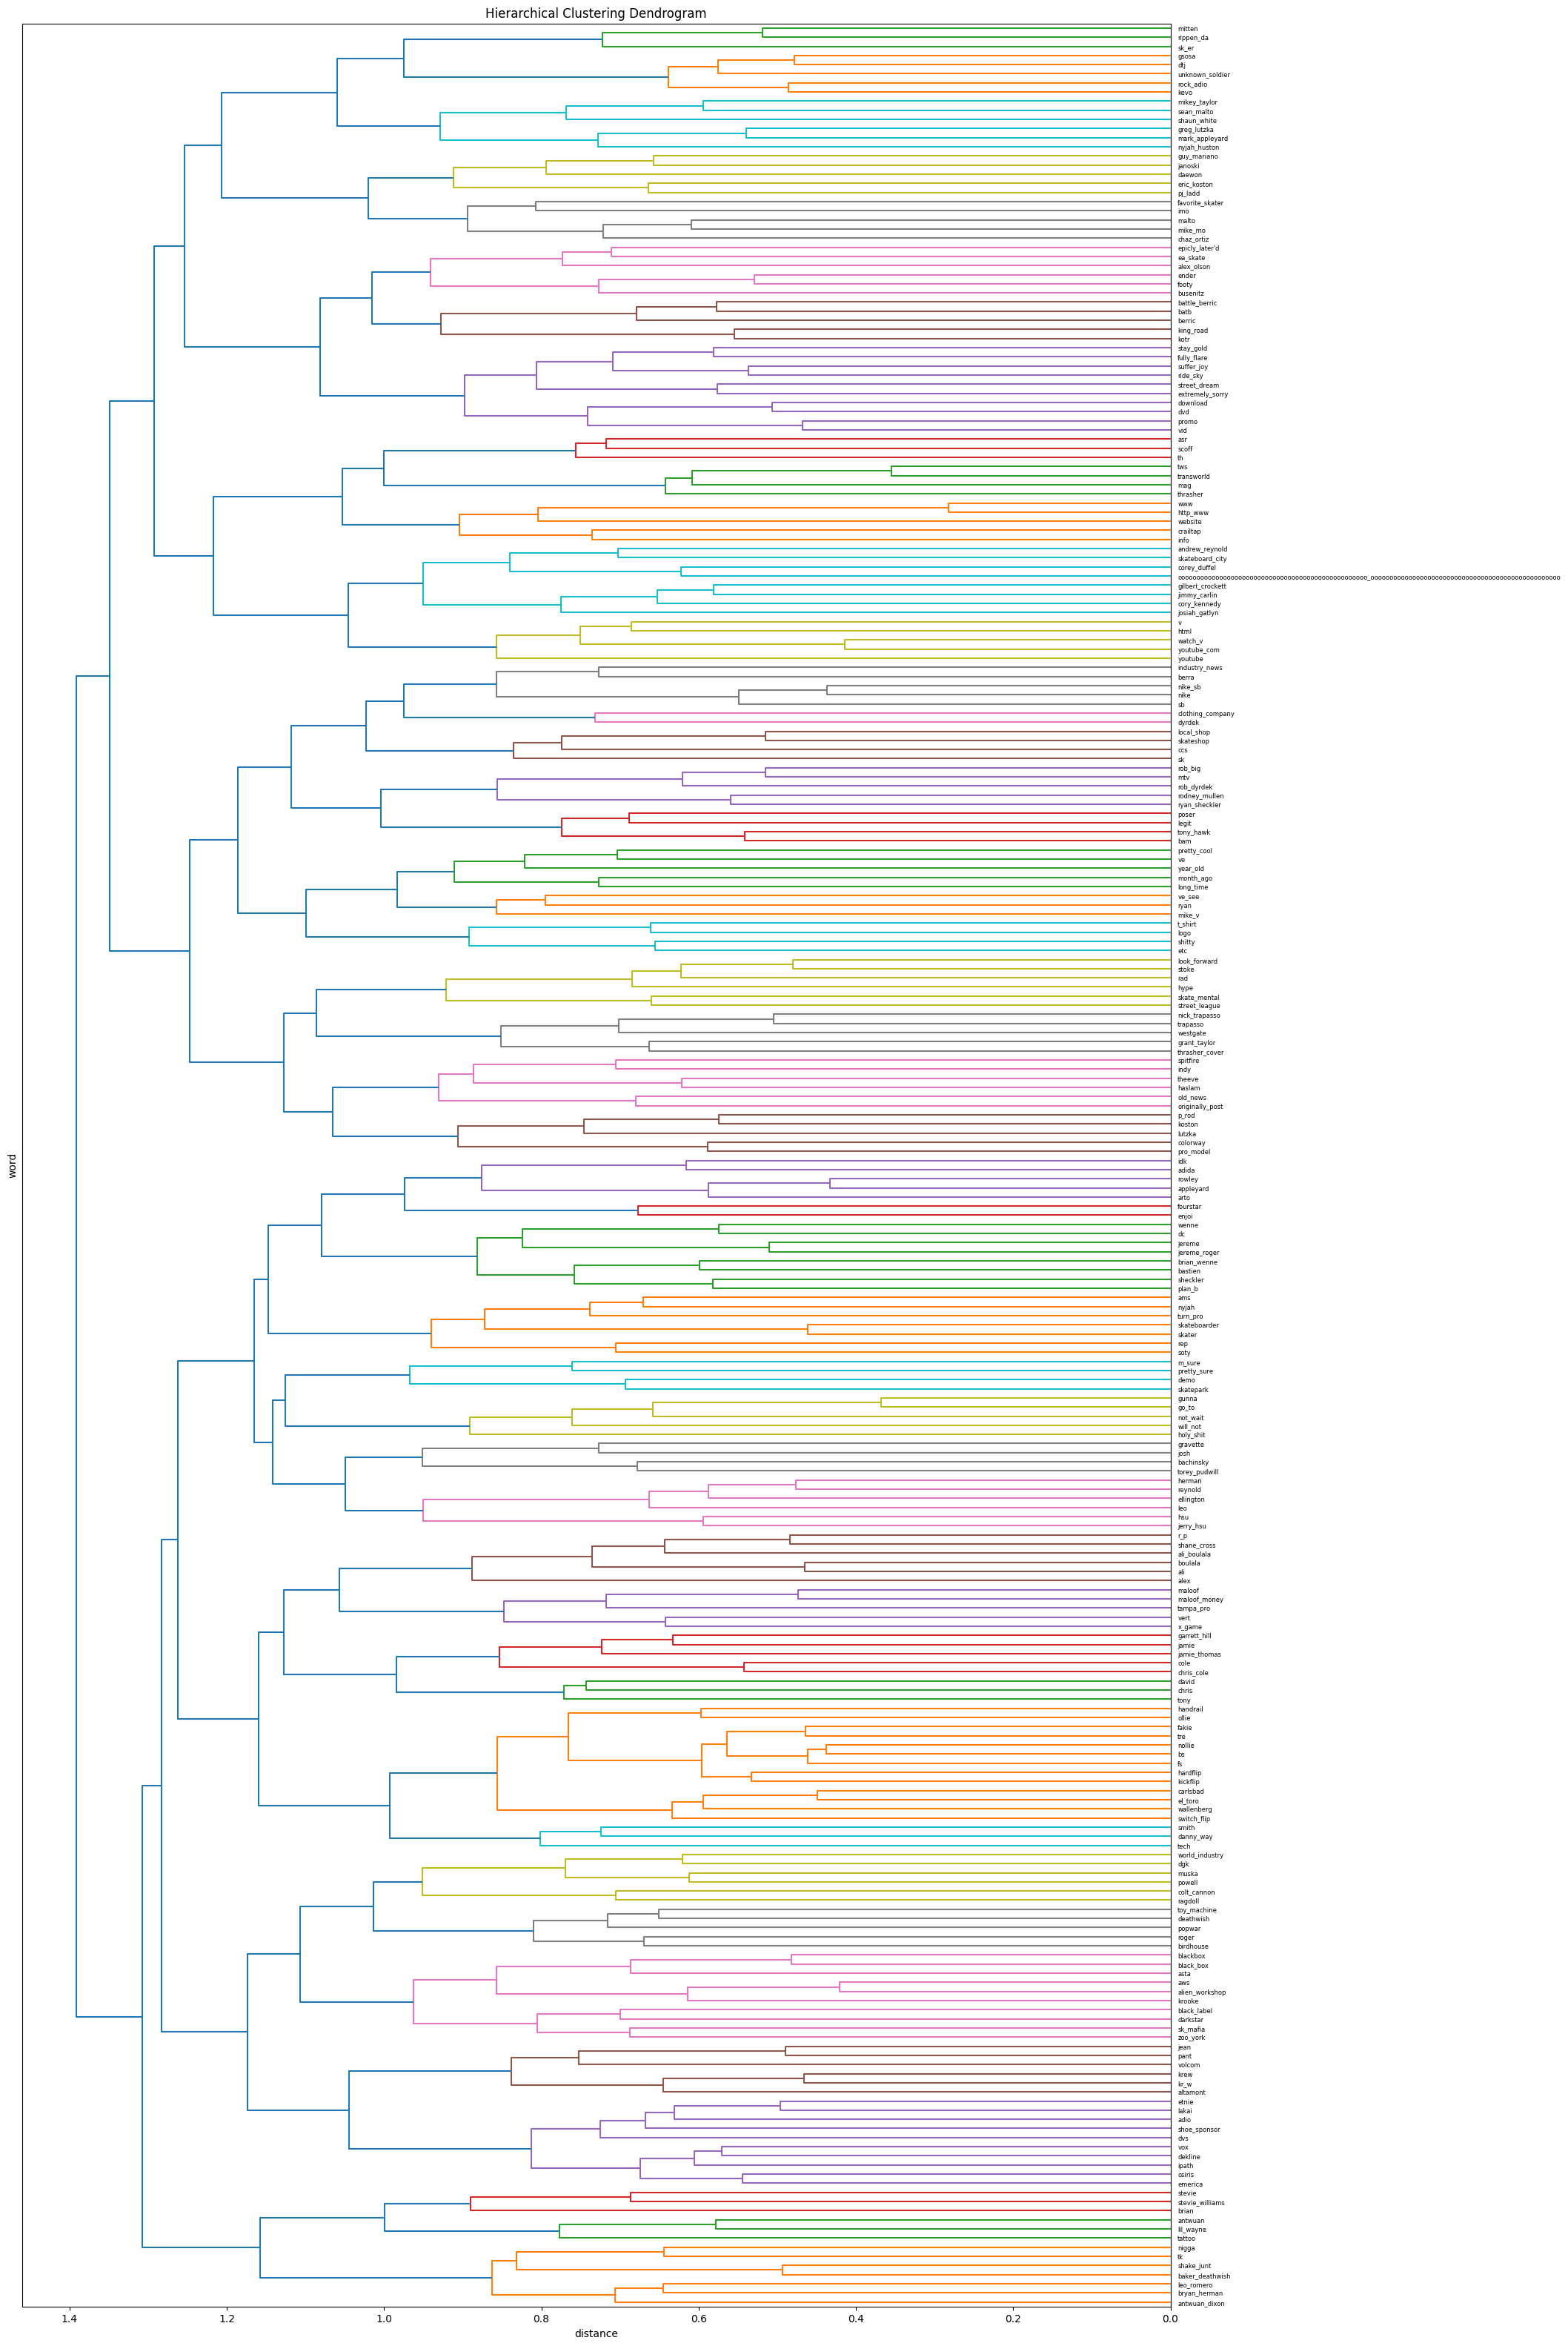

In [412]:
# base code citation (I modified it a bit)
# https://stackoverflow.com/questions/41462711/python-calculate-hierarchical-clustering-of-word2vec-vectors-and-plot-the-resu

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

# using cos dist
l = linkage(new_vectors, method='complete', metric='cosine')

# calculate full dendrogram
plt.figure(figsize=(20, 40))
plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('word')
plt.xlabel('distance')

d = dendrogram(
    l,
    leaf_font_size=6.,  # font size for the x axis labels
    orientation='left',
    labels=list(new_key_to_index.keys())[:250]
)
plt.show()

In [368]:
l.shape

(99, 4)

In [344]:
l[1, ].shape

(4,)